In [1]:
cd /content/drive/My Drive/Colab Notebooks/Neural Style Transfer

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer


## Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Model
import IPython.display as display
from PIL import Image

## Content Image

(1080, 1920, 3)


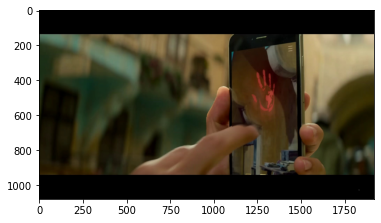

In [3]:
img = cv2.imread('frames_captured/frame0.jpg')[:, :, ::-1]
print(img.shape)
plt.imshow(img)


## Style Image

(4000, 6000, 3)


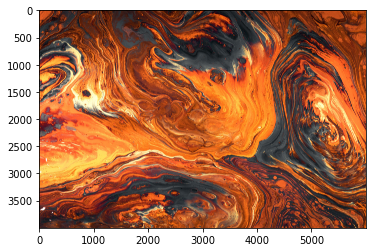

In [4]:
img = cv2.imread('style3.jpg')[:, :, ::-1]
print(img.shape)
plt.imshow(img)

## Pre-trained VGG19 Model

In [5]:
model = VGG19(include_top=False, weights='imagenet')
model.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

## Helper Functions

In [6]:
# Load and Preprocess image
def loadImage(path):
    print(path)
    img = cv2.imread(path)[:, :, ::-1]
    img = cv2.resize(img, (700, 600))
#    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [9]:
cd Neural Style Transfer

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer


In [10]:
# Loading content image
content_img = loadImage('content4.jpg')

# Loading style image
style_img = loadImage('style3.jpg')

content4.jpg
style3.jpg


## Content Image Model

In [11]:
# Considering outputs of conv3 layer in block5 of vgg19 architecture
outputs = model.get_layer('block5_conv3').output

# Defining the model inputs and outputs
content_model = Model(inputs=model.input, outputs=outputs)
content_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Style Image Model

In [12]:
# Considering conv1 layer of block1, block3 and block5 of vgg19 architecture 
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']

# Defining the model inputs and outputs
style_model = [Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers]

In [13]:
style_model[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


In [14]:
style_model[1].summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [15]:
style_model[2].summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

## Gram Matrix

In [16]:
def gramMatrix(inp):
    channels = int(inp.shape[-1])
    a = tf.reshape(inp, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram/tf.cast(n, tf.float32)

## Loss Functions

In [17]:
# content Loss
def contentLoss(content, generated):
    C = content_model(content)
    G = content_model(generated)
    loss = tf.reduce_mean(tf.square(C-G))
    return loss

In [18]:
# style Loss
def styleLoss(style, generated):
    J = 0
    for sm in style_model:
        S = sm(style)
        G = sm(generated)
        GS = gramMatrix(S)
        GG = gramMatrix(G)
        cost = tf.reduce_mean(tf.square(GS-GG))
        J += cost / 3.0
    return J

## Image Generation

In [19]:
def train(content, style='../style3.jpg', iterations=30, a=50, b=50):
    # loading content image
    content_img = loadImage(content)
    # loading style image
    style_img = loadImage(style)
    # declaring generated image
    generated = tf.Variable(content_img, dtype=tf.float32)
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=6)
    # Considering initial cost as infinity
    best_cost = np.inf
    # Currently the best image is none
    best_image = None
    # Training loop
    for i in range(iterations):
        with tf.GradientTape() as tape:
            # Loss between content and generated image
            content_loss = contentLoss(content_img, generated)
            # Loss between style and generated image
            style_loss = styleLoss(style_img, generated)
            # Weighted total loss 
            total_loss = a*content_loss + b*style_loss
        # Calculating gradients
        grads = tape.gradient(total_loss, generated)
        # Applying Gradient descent
        opt.apply_gradients([(grads, generated)])

        # Storing the minimum loss in best_cost and corresponding image in best_image
        if total_loss < best_cost:
            best_cost = total_loss
            best_image = generated.numpy()
        if (i+1)%10 == 0:
            print(f"Iteration : {i+1}\tLoss : {total_loss}")
        # Appending generated image at each iteration
    # Return the generated image with minimum total loss
    return best_image

In [20]:
cd frames_captured/

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/frames_captured


In [21]:
import os
generated_images = []
count = 0
for img_file in os.listdir():
    count += 1
    print(count, img_file)
    stylized_img = train(content=img_file)
    generated_images.append(stylized_img)

1 frame0.jpg
frame0.jpg
../style3.jpg
Iteration : 10	Loss : 7645605376.0
Iteration : 20	Loss : 3156146432.0
Iteration : 30	Loss : 1469946752.0
2 frame1.jpg
frame1.jpg
../style3.jpg
Iteration : 10	Loss : 7652069888.0
Iteration : 20	Loss : 3145867520.0
Iteration : 30	Loss : 1463995264.0
3 frame2.jpg
frame2.jpg
../style3.jpg
Iteration : 10	Loss : 7689793024.0
Iteration : 20	Loss : 3159125248.0
Iteration : 30	Loss : 1466704640.0
4 frame3.jpg
frame3.jpg
../style3.jpg
Iteration : 10	Loss : 7804395520.0
Iteration : 20	Loss : 3201980160.0
Iteration : 30	Loss : 1489559552.0
5 frame4.jpg
frame4.jpg
../style3.jpg
Iteration : 10	Loss : 7884555264.0
Iteration : 20	Loss : 3261064704.0
Iteration : 30	Loss : 1513224192.0
6 frame5.jpg
frame5.jpg
../style3.jpg
Iteration : 10	Loss : 8030559744.0
Iteration : 20	Loss : 3351926784.0
Iteration : 30	Loss : 1562077056.0
7 frame6.jpg
frame6.jpg
../style3.jpg
Iteration : 10	Loss : 8041388544.0
Iteration : 20	Loss : 3359300096.0
Iteration : 30	Loss : 1563526016.0

## Helper Functions

In [22]:
cd ..

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer


In [23]:
mkdir new_frames

In [24]:
cd new_frames

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/new_frames


In [25]:
import pickle
with open('new_frames.data', 'wb') as f:
    pickle.dump(generated_images, f)

In [26]:
ls

new_frames.data


In [27]:
images = generated_images.copy()

In [28]:
def deProcess(img):
    img[:, :, 0] += 103.94
    img[:, :, 1] += 116.78
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [30]:
def displayImage(img, filename):
    if len(img.shape) == 4:
        img = np.squeeze(img, axis=0)
    img = deProcess(img)
    cv2.imwrite(filename, img)

In [29]:
len(images)

368

In [31]:
for i in range(len(images)):
    print(i)
    temp_img = images[i]
    displayImage(temp_img, f'frame{i}.jpg')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
pwd

'/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/new_frames'